<h1>
Pattern Mining Workflow 1.0
</h1>

<h2>Linee Guida Progetto</h2><br>
1. Frequent patterns extraction with different values of support and different types (i.e. frequent, close, maximal), (6 points) <br>
2. Discussion of the most interesting frequent patterns and analyze how changes the number of patterns with respect to the min_sup parameter (7 points)<br>
3. Association rules extraction with different values of confidence (6 points)<br>
4. Discussion of the most interesting rules and analyze how changes the number of rules with respect to the min_confidence parameter, histogram of rules' confidence and lift (7 points)<br>
5. Use the most meaningful rules to replace missing values and evaluate the accuracy (2 points)<br>
6. Use the most meaningful rules to predict the target variable and evaluate the accuracy (2 points)

<b>0.0 - Imports, Help and Dataset Load</b>

In [1]:
!pip install pyfim
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fim import apriori
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

     |████████████████████████████████| 358kB 8.6MB/s 
  Created wheel for pyfim: filename=pyfim-6.28-cp36-cp36m-linux_x86_64.whl size=536925 sha256=776b82db4aea7c07587a53a859b6372922b0627382c56a874a389dd3edad6307
  Stored in directory: /root/.cache/pip/wheels/19/ac/b4/9ae8ceb2208d78b21b1157f8561cc4469d236b7d785e7422f1
Successfully built pyfim


In [ ]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

In [2]:
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/My Drive/DATA_MINING/'
df = pd.read_csv(directory+"ds_denormalizzato.csv",encoding="utf-8")
del df['Unnamed: 0']
df.head()

Mounted at /content/drive


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,52.000000,No,1.0,593.0,Research & Development,9.0,4,Medical,2,Male,88.0,3,3,Research Director,3,Single,8446.0,13782.0,9.0,No,17.0,3.0,3,0,20.0,2.000000,2,8.0,7.0,2.0,13.0
1,36.000000,No,1.0,1218.0,Research & Development,1.0,1,Life Sciences,2,Male,52.0,3,5,Manager,3,Divorced,4834.0,8213.0,1.0,Yes,14.0,3.0,3,1,21.0,3.000000,3,1.0,8.0,1.0,6.0
2,36.239998,No,2.0,530.0,Sales,16.0,3,Life Sciences,3,NoGender,36.0,3,2,Sales Executive,4,Divorced,4768.0,16130.0,1.0,Yes,25.0,3.0,3,1,7.0,4.000000,3,1.0,5.0,1.0,2.0
3,33.000000,No,1.0,953.0,Research & Development,5.0,4,Technical Degree,2,Male,65.0,3,1,Research Scientist,2,Single,2799.0,17674.0,2.0,No,14.0,3.0,2,0,12.0,1.000000,3,3.0,7.0,0.0,7.0
4,36.565412,No,1.0,1380.0,Research & Development,9.0,2,Life Sciences,3,Female,75.0,3,1,Laboratory Technician,4,Single,7978.0,6319.0,1.0,No,12.0,3.0,3,0,2.0,2.541481,3,10.0,2.0,2.0,1.0


In [3]:
df.groupby('Attrition').count()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
No,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930,930
Yes,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182


<b>0.1 - Binning for continuous features and values remapping (copyright Aria) </b>

In [5]:
#Mantengo una copia del dataset con i valori veri per sicurezza!
df_no_bin = df.copy()
#df_no_bin

<b>0.1.1 - Scelta del numero di bins</b> <br>
Potrebbe aver senso anche non usare lo stesso numero di bins per tutte le variabili!! Ex: forse 10 bins per Age è troppo (visto che va da 18 a 60 circa), mentre per variabili con range più alti 10 potrebbero essere pochi!

In [6]:
df['AgeBin'] = pd.cut(round(df['Age'].astype(int)), 4, right=False)
df['DailyRateBin'] = pd.cut(round(df['DailyRate'].astype(int)), 5, right=False)
df['DistanceFromHomeBin'] = pd.cut(round(df['DistanceFromHome'].astype(int)), 3, right=False)
df['HourlyRateBin'] = pd.cut(round(df['HourlyRate'].astype(int)), 5, right=False)
df['MonthlyIncomeBin'] = pd.cut(round(df['MonthlyIncome'].astype(int)), 5, right=False)
df['MonthlyRateBin'] = pd.cut(round(df['MonthlyRate'].astype(int)), 5, right=False)
df['PercentSalaryHikeBin'] = pd.cut(round(df['PercentSalaryHike'].astype(int)), 3, right=False)

df.drop(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike'], axis=1, inplace=True)


In [7]:
df['BusinessTravel'] = df['BusinessTravel'].astype(str) + '_BusinessTravel'
df['Attrition'] = df['Attrition'].astype(str) + '_Att'
df['Education'] = df['Education'].astype(str) + '_Edu'
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].astype(str) + '_EnvironmentSatisf'
df['JobInvolvement'] = df['JobInvolvement'].astype(str) + '_JobInvolvement'
df['JobLevel'] = df['JobLevel'].astype(str) + '_JobLevel'
df['JobSatisfaction'] = df['JobSatisfaction'].astype(str) + '_JobSatisfaction'
df['PerformanceRating'] = df['PerformanceRating'].astype(str) + '_PerformanceRating'
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].astype(str) + '_RelationshipSatisfaction'
df['YearsInCurrentRole'] = round(df['YearsInCurrentRole']).astype(str) + '_YearsInCurrentRole'
df['YearsSinceLastPromotion'] = df['YearsSinceLastPromotion'].astype(str) + '_YearsSinceLastPromotion'
df['YearsWithCurrManager'] = round(df['YearsWithCurrManager']).astype(str) + '_YearsWithCurrManager'
df['AgeBin'] = df['AgeBin'].astype(str) + '_Age'
df['DailyRateBin'] = df['DailyRateBin'].astype(str) + '_DailyRate'
df['HourlyRateBin'] = df['HourlyRateBin'].astype(str) + '_HourlyRate'
df['DistanceFromHomeBin'] = df['DistanceFromHomeBin'].astype(str) + '_DistanceFromHome'
df['MonthlyIncomeBin'] = df['MonthlyIncomeBin'].astype(str) + '_MonthlyIncome'
df['MonthlyRateBin'] = df['MonthlyRateBin'].astype(str) + '_MonthlyRate'
df['PercentSalaryHikeBin'] = df['PercentSalaryHikeBin'].astype(str) + '_PercentSalaryHike'
df['StockOptionLevel'] = df['StockOptionLevel'].astype(str) + '_StockOptionLevel'
df['TotalWorkingYears'] = round(df['TotalWorkingYears']).astype(str) + '_TotalWorkingYears'
df['TrainingTimesLastYear'] = round(df['TrainingTimesLastYear']).astype(str) + '_TrainingTimesLastYear'
df['WorkLifeBalance'] = df['WorkLifeBalance'].astype(str) + '_WorkLifeBalance'
df['YearsAtCompany'] = round(df['YearsAtCompany']).astype(str) + '_YearsAtCompany'
df['OverTime'] = df['OverTime'].astype(str) + '_OverTime'
df['NumCompaniesWorked'] = round(df['NumCompaniesWorked']).astype(str) + '_NumCompaniesWorked'

df.head()

,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBin,DailyRateBin,DistanceFromHomeBin,HourlyRateBin,MonthlyIncomeBin,MonthlyRateBin,PercentSalaryHikeBin
0,No_Att,1.0_BusinessTravel,Research & Development,4_Edu,Medical,2_EnvironmentSatisf,Male,3_JobInvolvement,3_JobLevel,Research Director,3_JobSatisfaction,Single,9.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,20.0_TotalWorkingYears,2.0_TrainingTimesLastYear,2_WorkLifeBalance,8.0_YearsAtCompany,7.0_YearsInCurrentRole,2.0_YearsSinceLastPromotion,13.0_YearsWithCurrManager,"[48.75, 59.041)_Age","[381.2, 660.4)_DailyRate","[1.0, 10.333)_DistanceFromHome","[86.0, 100.07)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[15.667, 20.333)_PercentSalaryHike"
1,No_Att,1.0_BusinessTravel,Research & Development,1_Edu,Life Sciences,2_EnvironmentSatisf,Male,3_JobInvolvement,5_JobLevel,Manager,3_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,21.0_TotalWorkingYears,3.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,8.0_YearsInCurrentRole,1.0_YearsSinceLastPromotion,6.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[939.6, 1218.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[44.0, 58.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[7077.4, 12057.8)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
2,No_Att,2.0_BusinessTravel,Sales,3_Edu,Life Sciences,3_EnvironmentSatisf,NoGender,3_JobInvolvement,2_JobLevel,Sales Executive,4_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,7.0_TotalWorkingYears,4.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,5.0_YearsInCurrentRole,1.0_YearsSinceLastPromotion,2.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[381.2, 660.4)_DailyRate","[10.333, 19.667)_DistanceFromHome","[30.0, 44.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[20.333, 25.014)_PercentSalaryHike"
3,No_Att,1.0_BusinessTravel,Research & Development,4_Edu,Technical Degree,2_EnvironmentSatisf,Male,3_JobInvolvement,1_JobLevel,Research Scientist,2_JobSatisfaction,Single,2.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,2_RelationshipSatisfaction,0_StockOptionLevel,12.0_TotalWorkingYears,1.0_TrainingTimesLastYear,3_WorkLifeBalance,3.0_YearsAtCompany,7.0_YearsInCurrentRole,0.0_YearsSinceLastPromotion,7.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[939.6, 1218.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[17038.2, 22018.6)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
4,No_Att,1.0_BusinessTravel,Research & Development,2_Edu,Life Sciences,3_EnvironmentSatisf,Female,3_JobInvolvement,1_JobLevel,Laboratory Technician,4_JobSatisfaction,Single,1.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,2.0_TotalWorkingYears,3.0_TrainingTimesLastYear,3_WorkLifeBalance,10.0_YearsAtCompany,2.0_YearsInCurrentRole,2.0_YearsSinceLastPromotion,1.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[1218.8, 1499.396)_DailyRate","[1.0, 10.333)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[2097.0, 7077.4)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"


In [8]:
df.isnull().sum()

Attrition                   0
BusinessTravel              0
Department                  0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
NumCompaniesWorked          0
OverTime                    0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
AgeBin                      0
DailyRateBin                0
DistanceFromHomeBin         0
HourlyRateBin               0
MonthlyIncomeBin            0
MonthlyRateBin              0
PercentSalaryHikeBin        0
dtype: int64

<b>0.1.2 - Creazione dei baskets</b>

In [9]:
baskets = df.values.tolist()
baskets

[['No_Att',
  '1.0_BusinessTravel',
  'Research & Development',
  '4_Edu',
  'Medical',
  '2_EnvironmentSatisf',
  'Male',
  '3_JobInvolvement',
  '3_JobLevel',
  'Research Director',
  '3_JobSatisfaction',
  'Single',
  '9.0_NumCompaniesWorked',
  'No_OverTime',
  '3.0_PerformanceRating',
  '3_RelationshipSatisfaction',
  '0_StockOptionLevel',
  '20.0_TotalWorkingYears',
  '2.0_TrainingTimesLastYear',
  '2_WorkLifeBalance',
  '8.0_YearsAtCompany',
  '7.0_YearsInCurrentRole',
  '2.0_YearsSinceLastPromotion',
  '13.0_YearsWithCurrManager',
  '[48.75, 59.041)_Age',
  '[381.2, 660.4)_DailyRate',
  '[1.0, 10.333)_DistanceFromHome',
  '[86.0, 100.07)_HourlyRate',
  '[4807.0, 8605.0)_MonthlyIncome',
  '[12057.8, 17038.2)_MonthlyRate',
  '[15.667, 20.333)_PercentSalaryHike'],
 ['No_Att',
  '1.0_BusinessTravel',
  'Research & Development',
  '1_Edu',
  'Life Sciences',
  '2_EnvironmentSatisf',
  'Male',
  '3_JobInvolvement',
  '5_JobLevel',
  'Manager',
  '3_JobSatisfaction',
  'Divorced',
  '

<h2>1. Frequent patterns extraction with different values of support and different types (i.e. frequent, close, maximal), (6 points) </h2>

Fisso zmin = 2, se poi vogliamo prendere quelli da 3 in su si fa presto a selezionarli. <br>
NOTA: Cambiare il support significa semplicemente prenderne meno dal totale, ovvero io potrei anche farlo una volta con support 1 e poi selezionare da lì quelli con support >= al valore che voglio.<br><br>
<b>COSA SI PUO' FARE OLTRE CHE CONTARE QUANTI SE NE TROVANO?? imo niente, bisogna usarli per fare rules extraction per poter dire qualcos'altro di interessante. IDEE??</b>

In [10]:
supp_soglie = np.arange(20, 81, 5) #Oltre 75 non ce ne sono
supp_soglie

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

<h3>Frequent</h3>

In [11]:
#Frequent
#supp_soglie = np.arange(20, 81, 5) #Oltre 75 non ce ne sono
frequent_values = []
for soglia in supp_soglie:
    frequent_values.append([soglia, []])
    setname = 'itemsets'+'_A_'+str(soglia)
    setname = apriori(baskets, supp=soglia, zmin=2, target='a', report='as') 
    print('# of itemsets with target A, zmin=2 and support '+str(soglia)+':', len(setname))
    len2 = len([x for x in setname if len(x[0])==2])
    #print('\t'+'\t'+ str(len2)+ ' of length 2')
    frequent_values[-1][1].append(len2)
    
    len3 = len([x for x in setname if len(x[0])==3])
    #print('\t'+'\t'+ str(len3)+ ' of length 3')
    frequent_values[-1][1].append(len3)
    
    len4 = len([x for x in setname if len(x[0])==4])
    #print('\t'+'\t'+ str(len4)+ ' of length 4')
    frequent_values[-1][1].append(len4)
    
    len5 = len([x for x in setname if len(x[0])==5])
    #print('\t'+'\t'+ str(len5)+ ' of length 5')
    frequent_values[-1][1].append(len5)

# of itemsets with target A, zmin=2 and support 20: 958
# of itemsets with target A, zmin=2 and support 25: 423
# of itemsets with target A, zmin=2 and support 30: 202
# of itemsets with target A, zmin=2 and support 35: 105
# of itemsets with target A, zmin=2 and support 40: 62
# of itemsets with target A, zmin=2 and support 45: 33
# of itemsets with target A, zmin=2 and support 50: 19
# of itemsets with target A, zmin=2 and support 55: 10
# of itemsets with target A, zmin=2 and support 60: 6
# of itemsets with target A, zmin=2 and support 65: 1
# of itemsets with target A, zmin=2 and support 70: 1
# of itemsets with target A, zmin=2 and support 75: 0
# of itemsets with target A, zmin=2 and support 80: 0


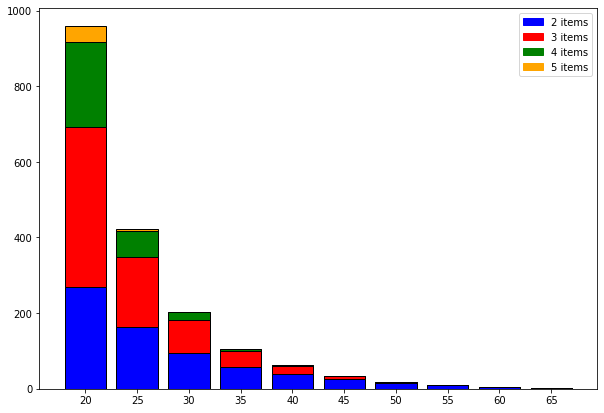

In [12]:
toplot = [x[1] for x in frequent_values]
plt.figure(figsize=(10, 7))
bar2 = [x[0] for x in toplot[:10]]
bar3 = [x[1] for x in toplot[:10]]
bar4 = [x[2] for x in toplot[:10]]
bar5 = [x[3] for x in toplot[:10]]
r = supp_soglie[:10]
barWidth = 4
bars = np.add(bar2, bar3).tolist()
bars2 = np.add(bars, bar4).tolist()
plt.xticks(supp_soglie[:10])

colors = {'2 items':'blue', '3 items':'red', '4 items':'green', '5 items':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(r, bar2, color='blue', edgecolor='black', width=barWidth)
plt.bar(r, bar3, bottom=bar2, color='red', edgecolor='black', width=barWidth)
plt.bar(r, bar4, bottom=bars, color='green', edgecolor='black', width=barWidth)
plt.bar(r, bar5, bottom=bars2, color='orange', edgecolor='black', width=barWidth)
plt.show()

<h3>Closed</h3>

In [13]:
#Closed
closed_values = []
for soglia in supp_soglie:
    closed_values.append([soglia, []])
    setname = 'itemsets'+'_A_'+str(soglia)
    setname = apriori(baskets, supp=soglia, zmin=2, target='c', report='as') 
    print('# of itemsets with target A, zmin=2 and support '+str(soglia)+':', len(setname))
    len2 = len([x for x in setname if len(x[0])==2])
    #print('\t'+'\t'+ str(len2)+ ' of length 2')
    closed_values[-1][1].append(len2)
    
    len3 = len([x for x in setname if len(x[0])==3])
    #print('\t'+'\t'+ str(len3)+ ' of length 3')
    closed_values[-1][1].append(len3)
    
    len4 = len([x for x in setname if len(x[0])==4])
    #print('\t'+'\t'+ str(len4)+ ' of length 4')
    closed_values[-1][1].append(len4)
    
    len5 = len([x for x in setname if len(x[0])==5])
    #print('\t'+'\t'+ str(len5)+ ' of length 5')
    closed_values[-1][1].append(len5)

# of itemsets with target A, zmin=2 and support 20: 947
# of itemsets with target A, zmin=2 and support 25: 422
# of itemsets with target A, zmin=2 and support 30: 202
# of itemsets with target A, zmin=2 and support 35: 105
# of itemsets with target A, zmin=2 and support 40: 62
# of itemsets with target A, zmin=2 and support 45: 33
# of itemsets with target A, zmin=2 and support 50: 19
# of itemsets with target A, zmin=2 and support 55: 10
# of itemsets with target A, zmin=2 and support 60: 6
# of itemsets with target A, zmin=2 and support 65: 1
# of itemsets with target A, zmin=2 and support 70: 1
# of itemsets with target A, zmin=2 and support 75: 0
# of itemsets with target A, zmin=2 and support 80: 0


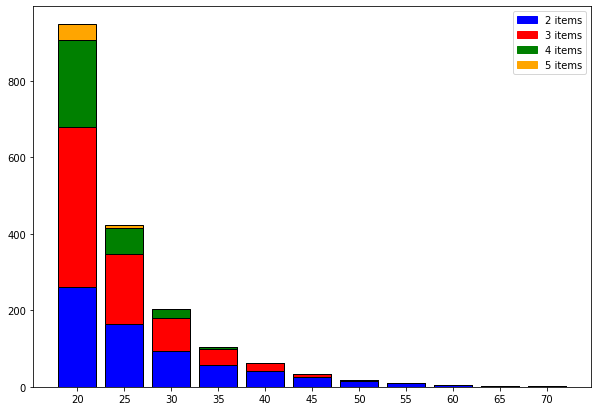

In [14]:
#Repeat the above steps.
toplot_closed = [x[1] for x in closed_values]
plt.figure(figsize=(10, 7))
bar2 = [x[0] for x in toplot_closed[:11]]
bar3 = [x[1] for x in toplot_closed[:11]]
bar4 = [x[2] for x in toplot_closed[:11]]
bar5 = [x[3] for x in toplot_closed[:11]]
r = supp_soglie[:11]
barWidth = 4
bars = np.add(bar2, bar3).tolist()
bars2 = np.add(bars, bar4).tolist()
plt.xticks(supp_soglie[:11])

colors = {'2 items':'blue', '3 items':'red', '4 items':'green', '5 items':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(r, bar2, color='blue', edgecolor='black', width=barWidth)
plt.bar(r, bar3, bottom=bar2, color='red', edgecolor='black', width=barWidth)
plt.bar(r, bar4, bottom=bars, color='green', edgecolor='black', width=barWidth)
plt.bar(r, bar5, bottom=bars2, color='orange', edgecolor='black', width=barWidth)
plt.show()

<h3>Maximal</h3>

In [15]:
#Maximal
maximal_values = []
for soglia in supp_soglie:
    maximal_values.append([soglia, []])
    setname = 'itemsets'+'_A_'+str(soglia)
    setname = apriori(baskets, supp=soglia, zmin=2, target='m', report='as') 
    print('# of itemsets with target A, zmin=2 and support '+str(soglia)+':', len(setname))
    len2 = len([x for x in setname if len(x[0])==2])
    #print('\t'+'\t'+ str(len2)+ ' of length 2')
    maximal_values[-1][1].append(len2)
    
    len3 = len([x for x in setname if len(x[0])==3])
    #print('\t'+'\t'+ str(len3)+ ' of length 3')
    maximal_values[-1][1].append(len3)
    
    len4 = len([x for x in setname if len(x[0])==4])
    #print('\t'+'\t'+ str(len4)+ ' of length 4')
    maximal_values[-1][1].append(len4)
    
    len5 = len([x for x in setname if len(x[0])==5])
    #print('\t'+'\t'+ str(len5)+ ' of length 5')
    maximal_values[-1][1].append(len5)

# of itemsets with target A, zmin=2 and support 20: 385
# of itemsets with target A, zmin=2 and support 25: 186
# of itemsets with target A, zmin=2 and support 30: 96
# of itemsets with target A, zmin=2 and support 35: 53
# of itemsets with target A, zmin=2 and support 40: 33
# of itemsets with target A, zmin=2 and support 45: 21
# of itemsets with target A, zmin=2 and support 50: 12
# of itemsets with target A, zmin=2 and support 55: 7
# of itemsets with target A, zmin=2 and support 60: 6
# of itemsets with target A, zmin=2 and support 65: 1
# of itemsets with target A, zmin=2 and support 70: 1
# of itemsets with target A, zmin=2 and support 75: 0
# of itemsets with target A, zmin=2 and support 80: 0


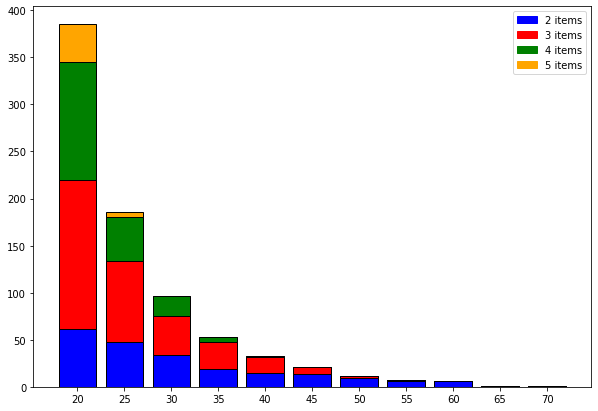

In [16]:
#Repeat the above steps
toplot_max = [x[1] for x in maximal_values]
plt.figure(figsize=(10, 7))
bar2 = [x[0] for x in toplot_max[:11]]
bar3 = [x[1] for x in toplot_max[:11]]
bar4 = [x[2] for x in toplot_max[:11]]
bar5 = [x[3] for x in toplot_max[:11]]
r = supp_soglie[:11]
barWidth = 4
bars = np.add(bar2, bar3).tolist()
bars2 = np.add(bars, bar4).tolist()
plt.xticks(supp_soglie[:11])

colors = {'2 items':'blue', '3 items':'red', '4 items':'green', '5 items':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(r, bar2, color='blue', edgecolor='black', width=barWidth)
plt.bar(r, bar3, bottom=bar2, color='red', edgecolor='black', width=barWidth)
plt.bar(r, bar4, bottom=bars, color='green', edgecolor='black', width=barWidth)
plt.bar(r, bar5, bottom=bars2, color='orange', edgecolor='black', width=barWidth)
plt.show()

<h3>Discussione</h3>
NOTA: Oltre minsup = 30 frequent e closed si equivalgono. <b>PROVIAMO A DARE UNA SPIEGAZIONE</b>, poi per fare le prove usiamo solo uno dei due (top!). <br>
NOTA: Quelli maximal sono per la maggior parte da 3 oggetti!

<h2>2. Discussion of the most interesting frequent patterns and analyze how changes the number of patterns with respect to the min_sup parameter (7 points)</h2>

Come cambia il numero dei patterns si vede da sopra (scende al salire di minsup... MA VA'???) <br>
Quali sono i più interessanti.... tocca scorrerli? In genere più supporto hanno e più oggetti contengono più sono "interessanti".

<b> Opzione 1: Creo un dataframe (filtrabile a piacimento) </b>

In [17]:
itemsets = apriori(baskets, supp=30, zmin=2, target='a', report='as')
maximal_itemsets = apriori(baskets, supp=30, zmin=2, target='m', report='as')
frequent_dict = {'n_items': [], 'items' : [], 'sup_count' : [], 'sup_perc': [], 'maximal' : []}
for x in itemsets:
    frequent_dict['n_items'].append(len(x[0]))
    frequent_dict['items'].append(x[0])
    frequent_dict['sup_count'].append(x[1])
    frequent_dict['sup_perc'].append(x[2])
    if x in maximal_itemsets:
        frequent_dict['maximal'].append('Yes')
    else:
        frequent_dict['maximal'].append('No')
        
freq_itemsets_df = pd.DataFrame(data = frequent_dict)
freq_itemsets_df
#freq_itemsets_df[freq_itemsets_df['n_items']>2].sort_values(by='sup_perc', ascending=False)
#freq_itemsets_df.to_csv('C:/Users/Andrea/Desktop/frequentitemsets_.csv')

,n_items,items,sup_count,sup_perc,maximal
0,2,"(Single, 0_StockOptionLevel)",360,0.323741,Yes
1,2,"(1.0_NumCompaniesWorked, 3.0_PerformanceRating)",357,0.321043,Yes
2,2,"(2_JobLevel, No_Att)",375,0.337230,Yes
3,2,"(2_JobLevel, 3.0_PerformanceRating)",354,0.318345,Yes
4,2,"(Female, No_Att)",362,0.325540,Yes
...,...,...,...,...,...
197,2,"(No_OverTime, 3.0_PerformanceRating)",686,0.616906,No
198,2,"(1.0_BusinessTravel, No_Att)",690,0.620504,No
199,3,"(1.0_BusinessTravel, No_Att, 3.0_PerformanceRa...",604,0.543165,No
200,2,"(1.0_BusinessTravel, 3.0_PerformanceRating)",720,0.647482,No


<b>I set con un supporto maggiore sono quelle che contengono valori la cui distribuzione è molto sbilanciata.</b>

In [18]:
regolefighe = []
regolefighe2 = []
for index, row in freq_itemsets_df.iterrows():
    if ('No_Att' not in row['items']) and ('No_OverTime' not in row['items']) and ('1.0_BusinessTravel' not in row['items']):
        regolefighe.append(row)
    
print('Regole senza No_Att:', len(regolefighe))

regoledaleggere = pd.DataFrame(regolefighe)
regoledaleggere.sort_values(by='sup_perc', ascending=False)
#regoledaleggere.to_csv('C:/Users/Andrea/Desktop/26itemsets.csv')

Regole senza No_Att: 61


,n_items,items,sup_count,sup_perc,maximal
190,2,"([1.0, 10.333)_DistanceFromHome, 3.0_Performan...",676,0.607914,No
176,2,"(Research & Development, 3.0_PerformanceRating)",640,0.575540,No
157,2,"([11.0, 15.667)_PercentSalaryHike, 3.0_Perform...",597,0.536871,No
134,2,"(3_WorkLifeBalance, 3.0_PerformanceRating)",591,0.531475,No
109,2,"(3_JobInvolvement, 3.0_PerformanceRating)",555,0.499101,No
...,...,...,...,...,...
49,2,"([28.25, 38.5)_Age, 3_JobInvolvement)",342,0.307554,Yes
50,2,"([28.25, 38.5)_Age, 3_WorkLifeBalance)",341,0.306655,Yes
89,3,"(3_JobInvolvement, 3_WorkLifeBalance, 3.0_Perf...",338,0.303957,Yes
40,2,"(3.0_TrainingTimesLastYear, Research & Develop...",338,0.303957,Yes


In [19]:
df_prova = df.copy()
todel = ['Attrition', 'BusinessTravel', 'Department', 'PerformanceRating', 'OverTime', 'JobInvolvement', 'WorkLifeBalance']
for col in todel:
    del df_prova[col]
newbaskets = df_prova.values.tolist()
itemsets_prova = apriori(newbaskets, supp=20, zmin=2, target='a', report='as')
maximal_itemsets_prova = apriori(newbaskets, supp=20, zmin=2, target='m', report='as')
frequent_dict_prova = {'n_items': [], 'items' : [], 'sup_count' : [], 'sup_perc': [], 'maximal' : []}
for x in itemsets_prova:
    frequent_dict_prova['n_items'].append(len(x[0]))
    frequent_dict_prova['items'].append(x[0])
    frequent_dict_prova['sup_count'].append(x[1])
    frequent_dict_prova['sup_perc'].append(x[2])
    if x in maximal_itemsets_prova:
        frequent_dict_prova['maximal'].append('Yes')
    else:
        frequent_dict_prova['maximal'].append('No')
        
freq_itemsets_df_prova = pd.DataFrame(data = frequent_dict_prova)
freq_itemsets_df_prova

,n_items,items,sup_count,sup_perc,maximal
0,2,"(4_RelationshipSatisfaction, [1.0, 10.333)_Dis...",230,0.206835,Yes
1,2,"(3_JobSatisfaction, [1.0, 10.333)_DistanceFrom...",230,0.206835,Yes
2,2,"(4_EnvironmentSatisf, [1.0, 10.333)_DistanceFr...",233,0.209532,Yes
3,2,"(4_JobSatisfaction, [1.0, 10.333)_DistanceFrom...",234,0.210432,Yes
4,2,"(3_RelationshipSatisfaction, [1.0, 10.333)_Dis...",230,0.206835,Yes
...,...,...,...,...,...
69,2,"([28.25, 38.5)_Age, [1.0, 10.333)_DistanceFrom...",401,0.360612,No
70,2,"(Male, [11.0, 15.667)_PercentSalaryHike)",406,0.365108,No
71,3,"(Male, [11.0, 15.667)_PercentSalaryHike, [1.0,...",275,0.247302,Yes
72,2,"(Male, [1.0, 10.333)_DistanceFromHome)",431,0.387590,No


In [20]:
'''#calcoliamo le lunghezze per supporto con target diversi
length_a = []
length_c = []
length_m = []
for x in range(1,74):
    itemsets_a = apriori(baskets, target='s', supp=x, report='s', zmin=2)
    itemsets_c = apriori(baskets, target='c', supp=x, report='s', zmin=2)
    itemsets_m = apriori(baskets, target='m', supp=x, report='s', zmin=2)
    length_a.append(len(itemsets_a))
    length_c.append(len(itemsets_c))
    length_m.append(len(itemsets_m))'''

"#calcoliamo le lunghezze per supporto con target diversi\nlength_a = []\nlength_c = []\nlength_m = []\nfor x in range(1,74):\n    itemsets_a = apriori(baskets, target='s', supp=x, report='s', zmin=2)\n    itemsets_c = apriori(baskets, target='c', supp=x, report='s', zmin=2)\n    itemsets_m = apriori(baskets, target='m', supp=x, report='s', zmin=2)\n    length_a.append(len(itemsets_a))\n    length_c.append(len(itemsets_c))\n    length_m.append(len(itemsets_m))"

In [21]:
'''#vediamo che oltre la soglia 8/10 di support closed e frequent diventano uguali
plt.figure(figsize=(15,7))
plt.plot(length_a[5:25])
plt.plot(length_c[5:25])
plt.plot(length_m[5:25])
plt.grid()
plt.ylabel('# Itemsets')
plt.xlabel('Min_Support')
plt.show()'''

"#vediamo che oltre la soglia 8/10 di support closed e frequent diventano uguali\nplt.figure(figsize=(15,7))\nplt.plot(length_a[5:25])\nplt.plot(length_c[5:25])\nplt.plot(length_m[5:25])\nplt.grid()\nplt.ylabel('# Itemsets')\nplt.xlabel('Min_Support')\nplt.show()"

<b>Opzione 2: Li stampo a blocchi per vederli tutti. Fa un po' schifo. Si può fare anche sul dataframe per renderlo più carino, ormai l'ho fatto così sorry. </b>

In [22]:
print('Patterns con supporto maggiore di 65%:')
print()
for x in itemsets:
    if x[2]>=0.65:
        print(x)

Patterns con supporto maggiore di 65%:

(('No_Att', '3.0_PerformanceRating'), 811, 0.72931654676259)


In [23]:
print('Patterns con supporto compreso tra 55% e 65%:')
print()
for x in itemsets:
    if x[2]>=0.55 and x[2]<0.65:
        print(x)

Patterns con supporto compreso tra 55% e 65%:

(('Research & Development', 'No_Att'), 626, 0.5629496402877698)
(('Research & Development', '3.0_PerformanceRating'), 640, 0.5755395683453237)
(('[1.0, 10.333)_DistanceFromHome', 'No_Att'), 659, 0.5926258992805755)
(('[1.0, 10.333)_DistanceFromHome', '3.0_PerformanceRating'), 676, 0.6079136690647482)
(('No_OverTime', 'No_Att'), 706, 0.6348920863309353)
(('No_OverTime', 'No_Att', '3.0_PerformanceRating'), 614, 0.552158273381295)
(('No_OverTime', '3.0_PerformanceRating'), 686, 0.6169064748201439)
(('1.0_BusinessTravel', 'No_Att'), 690, 0.6205035971223022)
(('1.0_BusinessTravel', '3.0_PerformanceRating'), 720, 0.6474820143884892)


In [24]:
print('Patterns con supporto compreso tra 45% e 55%:')
print()
for x in itemsets:
    if x[2]>=0.45 and x[2]<0.55:
        print(x)

Patterns con supporto compreso tra 45% e 55%:

(('[28.25, 38.5)_Age', '3.0_PerformanceRating'), 502, 0.45143884892086333)
(('Male', 'No_Att'), 521, 0.4685251798561151)
(('Male', '3.0_PerformanceRating'), 541, 0.48651079136690645)
(('3_JobInvolvement', 'No_Att'), 555, 0.49910071942446044)
(('3_JobInvolvement', '3.0_PerformanceRating'), 555, 0.49910071942446044)
(('3_WorkLifeBalance', '1.0_BusinessTravel'), 508, 0.4568345323741007)
(('3_WorkLifeBalance', 'No_Att'), 579, 0.52068345323741)
(('3_WorkLifeBalance', 'No_Att', '3.0_PerformanceRating'), 511, 0.4595323741007194)
(('3_WorkLifeBalance', '3.0_PerformanceRating'), 591, 0.5314748201438849)
(('[11.0, 15.667)_PercentSalaryHike', '1.0_BusinessTravel'), 525, 0.4721223021582734)
(('[11.0, 15.667)_PercentSalaryHike', 'No_Att'), 578, 0.5197841726618705)
(('[11.0, 15.667)_PercentSalaryHike', '3.0_PerformanceRating'), 597, 0.5368705035971223)
(('Research & Development', '[1.0, 10.333)_DistanceFromHome'), 510, 0.45863309352517984)
(('Research &

In [25]:
print('Patterns con supporto compreso tra 40% e 45%:')
print()
for x in itemsets:
    if x[2]>=0.40 and x[2]<0.45:
        print(x)

Patterns con supporto compreso tra 40% e 45%:

(('Married', 'No_Att'), 452, 0.4064748201438849)
(('Married', '3.0_PerformanceRating'), 445, 0.4001798561151079)
(('3.0_TrainingTimesLastYear', '3.0_PerformanceRating'), 450, 0.40467625899280574)
(('[28.25, 38.5)_Age', 'No_Att'), 489, 0.4397482014388489)
(('Male', 'No_OverTime'), 447, 0.40197841726618705)
(('Male', '1.0_BusinessTravel'), 457, 0.41097122302158273)
(('Male', 'No_Att', '3.0_PerformanceRating'), 456, 0.41007194244604317)
(('3_JobInvolvement', '[1.0, 10.333)_DistanceFromHome'), 445, 0.4001798561151079)
(('3_JobInvolvement', 'No_OverTime'), 463, 0.41636690647482016)
(('3_JobInvolvement', '1.0_BusinessTravel'), 473, 0.42535971223021585)
(('3_JobInvolvement', 'No_Att', '3.0_PerformanceRating'), 475, 0.427158273381295)
(('3_WorkLifeBalance', '[1.0, 10.333)_DistanceFromHome'), 472, 0.4244604316546763)
(('3_WorkLifeBalance', 'No_OverTime'), 480, 0.4316546762589928)
(('3_WorkLifeBalance', '1.0_BusinessTravel', '3.0_PerformanceRating')

In [26]:
print('Patterns con supporto compreso tra 35% e 40%:')
print()
for x in itemsets:
    if x[2]>=0.35 and x[2]<0.40:
        print(x)

Patterns con supporto compreso tra 35% e 40%:

(('1_StockOptionLevel', 'No_Att'), 405, 0.3642086330935252)
(('Life Sciences', 'No_Att'), 393, 0.3534172661870504)
(('Life Sciences', '3.0_PerformanceRating'), 393, 0.3534172661870504)
(('0.0_YearsSinceLastPromotion', '3.0_PerformanceRating'), 410, 0.368705035971223)
(('0_StockOptionLevel', '3.0_PerformanceRating'), 421, 0.37859712230215825)
(('Married', '1.0_BusinessTravel'), 391, 0.3516187050359712)
(('Married', 'No_Att', '3.0_PerformanceRating'), 393, 0.3534172661870504)
(('3.0_TrainingTimesLastYear', 'No_Att'), 428, 0.38489208633093525)
(('[28.25, 38.5)_Age', '[1.0, 10.333)_DistanceFromHome'), 401, 0.3606115107913669)
(('[28.25, 38.5)_Age', 'No_OverTime'), 413, 0.37140287769784175)
(('[28.25, 38.5)_Age', '1.0_BusinessTravel'), 422, 0.37949640287769787)
(('[28.25, 38.5)_Age', 'No_Att', '3.0_PerformanceRating'), 425, 0.38219424460431656)
(('Male', '[11.0, 15.667)_PercentSalaryHike'), 406, 0.36510791366906475)
(('Male', 'Research & Develo

In [27]:
print('Patterns con supporto compreso tra 30% e 35%:')
print()
for x in itemsets:
    if x[2]>=0.30 and x[2]<0.35:
        print(x)

Patterns con supporto compreso tra 30% e 35%:

(('Single', '0_StockOptionLevel'), 360, 0.3237410071942446)
(('1.0_NumCompaniesWorked', '3.0_PerformanceRating'), 357, 0.3210431654676259)
(('2_JobLevel', 'No_Att'), 375, 0.33723021582733814)
(('2_JobLevel', '3.0_PerformanceRating'), 354, 0.3183453237410072)
(('Female', 'No_Att'), 362, 0.3255395683453237)
(('Female', '3.0_PerformanceRating'), 381, 0.3426258992805755)
(('3_Edu', '1.0_BusinessTravel'), 336, 0.302158273381295)
(('3_Edu', 'No_Att'), 356, 0.32014388489208634)
(('3_Edu', '3.0_PerformanceRating'), 381, 0.3426258992805755)
(('[1009.0, 4807.0)_MonthlyIncome', 'No_Att'), 370, 0.3327338129496403)
(('[1009.0, 4807.0)_MonthlyIncome', '3.0_PerformanceRating'), 380, 0.34172661870503596)
(('1_JobLevel', 'Research & Development'), 350, 0.3147482014388489)
(('1_JobLevel', '3.0_PerformanceRating'), 383, 0.3444244604316547)
(('1_StockOptionLevel', 'No_Att', '3.0_PerformanceRating'), 357, 0.3210431654676259)
(('1_StockOptionLevel', '3.0_Perfor

In [28]:
#TODO: Fare commenti (da fare insieme)
#magari controllare quali di questi sono anche maximal (dal dataframe in opzione1 si vede bene).

<h2> 3. Association rules extraction with different values of confidence (6 points)</h2>
<h2> 4. Discussion of the most interesting rules and analyze how changes the number of rules with respect to the min_confidence parameter, histogram of rules' confidence and lift (7 points)</h2>

<b> Sono scemo o il punto 3 è semplicemente incluso nel punto 4????? </b>

Scegliere adesso se usare frequent o maximal patterns e con che soglia di minimum support? O fare prove? in teoria in questa fase dovremmo variare solo la confidence, se prendiamo la consegna alla lettera... 

In [49]:
rules = apriori(baskets, supp=25, zmin=2, target='r', conf=50, 
                report='aScl') 
print(len(rules))
print(rules[0])

4107
('Research Scientist', ('1_JobLevel', 'Research & Development', '3.0_PerformanceRating'), 171, 15.377697841726617, 0.5551948051948052, 2.604964655597567)


<b>ANALIZZARE RULES PIU INTERESSANTI</b>

In [50]:
rules_dict = {'len_ant' : [], 'Antecedent -->': [], 'Consequent' : [], 'sup_count' : [], 'sup_perc': [], 'Confidence': [], 'Lift' : []}
for x in rules:
    rules_dict['Antecedent -->'].append(x[1])
    rules_dict['Consequent'].append(x[0])
    rules_dict['len_ant'].append(len(x[1]))
    rules_dict['sup_count'].append(x[2])
    rules_dict['sup_perc'].append(x[3])
    rules_dict['Confidence'].append(x[4])
    rules_dict['Lift'].append(x[5])
        
rules_df = pd.DataFrame(data = rules_dict)
rules_df[(rules_df['Confidence']>=0.65) & (rules_df['Lift']>=1.2)].sort_values(by=['Lift', 'Confidence'], ascending=False)

,len_ant,Antecedent -->,Consequent,sup_count,sup_perc,Confidence,Lift
3,1,"(Sales,)",Sales Executive,244,21.942446,0.726190,3.309524
2,2,"(Sales, 3.0_PerformanceRating)",Sales Executive,208,18.705036,0.719723,3.280050
349,2,"(0_StockOptionLevel, No_OverTime)",Single,261,23.471223,0.765396,2.364223
347,3,"(0_StockOptionLevel, No_OverTime, 3.0_Performa...",Single,227,20.413669,0.764310,2.360868
345,3,"(0_StockOptionLevel, No_OverTime, No_Att)",Single,215,19.334532,0.759717,2.346682
334,2,"(0_StockOptionLevel, 3_WorkLifeBalance)",Single,225,20.233813,0.755034,2.332215
340,2,"(0_StockOptionLevel, Research & Development)",Single,231,20.773381,0.752443,2.324213
359,2,"(Single, 3.0_PerformanceRating)",0_StockOptionLevel,313,28.147482,1.000000,2.302277
361,1,"(Single,)",0_StockOptionLevel,360,32.374101,1.000000,2.302277
362,1,"(0_StockOptionLevel,)",Single,360,32.374101,0.745342,2.302277


<b>Commenti</b><br>
Mostriamo lift > 1.1 <br>
0 Stock Option e Single ricorrono molto spesso insieme. <br>

In [ ]:
#Conta in base alla confidence
conf_range = np.arange(30, 96, 5)
print(conf_range)
for conf in conf_range:
    print('Number of rules with confidence at least', str(conf)+'%: '+str(len(rules_df[rules_df['Confidence']>=conf*0.01])))

[30 35 40 45 50 55 60 65 70 75 80 85 90 95]
Number of rules with confidence at least 30%: 987
Number of rules with confidence at least 35%: 987
Number of rules with confidence at least 40%: 987
Number of rules with confidence at least 45%: 987
Number of rules with confidence at least 50%: 987
Number of rules with confidence at least 55%: 987
Number of rules with confidence at least 60%: 987
Number of rules with confidence at least 65%: 987
Number of rules with confidence at least 70%: 727
Number of rules with confidence at least 75%: 397
Number of rules with confidence at least 80%: 283
Number of rules with confidence at least 85%: 234
Number of rules with confidence at least 90%: 21
Number of rules with confidence at least 95%: 1


Istogrammi (DA MIGLIORARE)

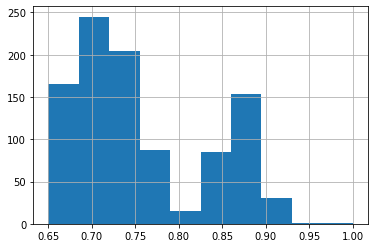

In [ ]:
rules_df['Confidence'].hist()

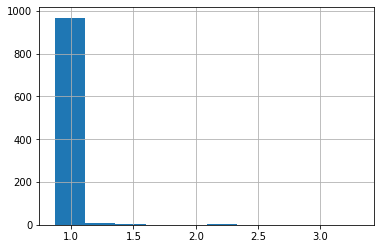

In [ ]:
rules_df['Lift'].hist()

<h2>5. Use the most meaningful rules to replace missing values and evaluate the accuracy (2 points)</h2>

Da fare insieme

In [ ]:
missing_df = df.copy()
#del missing_df['Unnamed: 0']
missing_df

,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBin,DailyRateBin,DistanceFromHomeBin,HourlyRateBin,MonthlyIncomeBin,MonthlyRateBin,PercentSalaryHikeBin
0,No_Att,1.0_BusinessTravel,Research & Development,4_Edu,Medical,2_EnvironmentSatisf,Male,3_JobInvolvement,3_JobLevel,Research Director,3_JobSatisfaction,Single,9.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,20.0_TotalWorkingYears,2.0_TrainingTimesLastYear,2_WorkLifeBalance,8.0_YearsAtCompany,7.0_YearsInCurrentRole,2.0_YearsSinceLastPromotion,13.0_YearsWithCurrManager,"[48.75, 59.041)_Age","[381.2, 660.4)_DailyRate","[1.0, 10.333)_DistanceFromHome","[86.0, 100.07)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[15.667, 20.333)_PercentSalaryHike"
1,No_Att,1.0_BusinessTravel,Research & Development,1_Edu,Life Sciences,2_EnvironmentSatisf,Male,3_JobInvolvement,5_JobLevel,Manager,3_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,21.0_TotalWorkingYears,3.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,8.0_YearsInCurrentRole,1.0_YearsSinceLastPromotion,6.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[939.6, 1218.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[44.0, 58.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[7077.4, 12057.8)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
2,No_Att,2.0_BusinessTravel,Sales,3_Edu,Life Sciences,3_EnvironmentSatisf,NoGender,3_JobInvolvement,2_JobLevel,Sales Executive,4_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,7.0_TotalWorkingYears,4.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,5.0_YearsInCurrentRole,1.0_YearsSinceLastPromotion,2.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[381.2, 660.4)_DailyRate","[10.333, 19.667)_DistanceFromHome","[30.0, 44.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[20.333, 25.014)_PercentSalaryHike"
3,No_Att,1.0_BusinessTravel,Research & Development,4_Edu,Technical Degree,2_EnvironmentSatisf,Male,3_JobInvolvement,1_JobLevel,Research Scientist,2_JobSatisfaction,Single,2.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,2_RelationshipSatisfaction,0_StockOptionLevel,12.0_TotalWorkingYears,1.0_TrainingTimesLastYear,3_WorkLifeBalance,3.0_YearsAtCompany,7.0_YearsInCurrentRole,0.0_YearsSinceLastPromotion,7.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[939.6, 1218.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[17038.2, 22018.6)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
4,No_Att,1.0_BusinessTravel,Research & Development,2_Edu,Life Sciences,3_EnvironmentSatisf,Female,3_JobInvolvement,1_JobLevel,Laboratory Technician,4_JobSatisfaction,Single,1.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,2.0_TotalWorkingYears,3.0_TrainingTimesLastYear,3_WorkLifeBalance,10.0_YearsAtCompany,2.0_YearsInCurrentRole,2.0_YearsSinceLastPromotion,1.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[1218.8, 1499.396)_DailyRate","[1.0, 10.333)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[2097.0, 7077.4)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,No_Att,1.0_BusinessTravel,Research & Development,2_Edu,Medical,4_EnvironmentSatisf,Female,4_JobInvolvement,1_JobLevel,Laboratory Technician,4_JobSatisfaction,Divorced,1.0_NumCompaniesWorke

In [ ]:
missing_df['MaritalStatusTrue'] = missing_df['MaritalStatus'].values
#missing_df

In [ ]:
missing_df.loc[missing_df.sample(frac=0.1, random_state=5).index, 'MaritalStatus'] = np.nan
missing_df['MaritalStatus']

0         Single
1       Divorced
2       Divorced
3            NaN
4         Single
          ...   
1107    Divorced
1108     Married
1109     Married
1110      Single
1111      Single
Name: MaritalStatus, Length: 1112, dtype: object

In [ ]:
missing_df['MaritalStatus'].isnull().sum()

111

In [ ]:
rules_marital = rules_df[((rules_df['Consequent']=='Single') | (rules_df['Consequent']=='Married')) & (rules_df['Confidence']>=0.65) & (rules_df['Lift']>=1.4) & (rules_df['len_ant']>=1)]
print(len(rules_marital))
rules_marital.sort_values(by=['Lift'], ascending=False)

10


,len_ant,Antecedent -->,Consequent,sup_count,sup_perc,Confidence,Lift
33,2,"(0_StockOptionLevel, No_OverTime)",Single,261,23.471223,0.765396,2.364223
41,1,"(0_StockOptionLevel,)",Single,360,32.374101,0.745342,2.302277
31,2,"(0_StockOptionLevel, [1.0, 10.333)_DistanceFro...",Single,264,23.741007,0.743662,2.297089
39,2,"(0_StockOptionLevel, 3.0_PerformanceRating)",Single,313,28.147482,0.743468,2.296490
37,2,"(0_StockOptionLevel, No_Att)",Single,266,23.920863,0.734807,2.269736
35,2,"(0_StockOptionLevel, 1.0_BusinessTravel)",Single,251,22.571942,0.713068,2.202588
139,2,"(1_StockOptionLevel, No_Att)",Married,279,25.089928,0.688889,1.487465
141,1,"(1_StockOptionLevel,)",Married,307,27.607914,0.686801,1.482956
138,3,"(1_StockOptionLevel, No_Att, 3.0_PerformanceRa...",Married,242,21.762590,0.677871,1.463675
140,2,"(1_StockOptionLevel, 3.0_PerformanceRating)",Married,262,23.561151,0.673522,1.454284


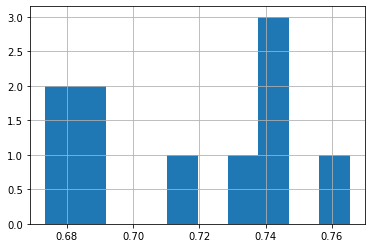

In [ ]:
rules_marital['Confidence'].hist()

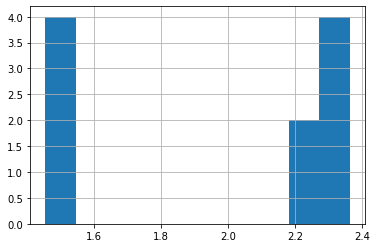

In [ ]:
rules_marital['Lift'].hist()

In [ ]:
antecedents_Single = rules_marital[rules_marital['Consequent']=='Single']['Antecedent -->'].values
antecedents_Single 

array([('0_StockOptionLevel', '[1.0, 10.333)_DistanceFromHome'),
       ('0_StockOptionLevel', 'No_OverTime'),
       ('0_StockOptionLevel', '1.0_BusinessTravel'),
       ('0_StockOptionLevel', 'No_Att'),
       ('0_StockOptionLevel', '3.0_PerformanceRating'),
       ('0_StockOptionLevel',)], dtype=object)

In [ ]:
antecedents_Married = rules_marital[rules_marital['Consequent']=='Married']['Antecedent -->'].values
antecedents_Married

array([('1_StockOptionLevel', 'No_Att', '3.0_PerformanceRating'),
       ('1_StockOptionLevel', 'No_Att'),
       ('1_StockOptionLevel', '3.0_PerformanceRating'),
       ('1_StockOptionLevel',)], dtype=object)

In [ ]:
missing_df.insert(1,'MaritalStatusPrediction','')
#missing_df['MaritalStatusPrediction'] = 'Divorced' 
missing_df['MaritalStatusPrediction'] = np.nan

missing_df[['MaritalStatus', 'MaritalStatusPrediction', 'MaritalStatusTrue']].head()

,MaritalStatus,MaritalStatusPrediction,MaritalStatusTrue
0,Single,NaN,Single
1,Divorced,NaN,Divorced
2,Divorced,NaN,Divorced
3,NaN,NaN,Single
4,Single,NaN,Single


In [ ]:
prediction_df = missing_df.copy()
#prediction_df = dataset con valori mancanti originario 
#che va binnato e gestito come per missing_df/target_df etc

pred_values = prediction_df.values

#prendo tutte le regole con no_att come conseguente. Inserire qui un metodo di selezione.
#antecedents_Single = rules_marital[rules_marital['Consequent']=='Single']['Antecedent -->'].values
#antecedents_Single 


for n, item in enumerate(pred_values):
    set_tocheck = set(item)
    for rule in antecedents_Single: #for rule in best_rules
      myset = set(rule)
      if myset.issubset(set_tocheck):
         prediction_df.loc[n, 'MaritalStatusPrediction'] = 'Single' #non ho nessun modo per rintracciare dove mettere il valore predetto
         #break
    for rule in antecedents_Married:
      myset = set(rule)
      if myset.issubset(set_tocheck):
        prediction_df.loc[n, 'MaritalStatusPrediction'] = 'Married'
        #break
    

#print(len(prediction_df[prediction_df['Attr_Prediction']=='No_Att']))            
prediction_df[['MaritalStatus', 'MaritalStatusPrediction', 'MaritalStatusTrue']]#.tolist()           
#mylist = ['Yes_Att', 'No_Patterns', 'Yes_OverTime']
#myset = set(mylist)
#myset.issubset(set(prediction_df.values[0])) 
#df.loc[2, 'D1'] = 32

,MaritalStatus,MaritalStatusPrediction,MaritalStatusTrue
0,Single,Single,Single
1,Divorced,Married,Divorced
2,Divorced,Married,Divorced
3,NaN,Single,Single
4,Single,Single,Single
...,...,...,...
1107,Divorced,NaN,Divorced
1108,Married,Single,Married
1109,Married,Single,Married
1110,Single,Single,Single


In [ ]:
df_cut = prediction_df[prediction_df['MaritalStatusPrediction'].isna()]
df_cut

,Attrition,MaritalStatusPrediction,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBin,DailyRateBin,DistanceFromHomeBin,HourlyRateBin,MonthlyIncomeBin,MonthlyRateBin,PercentSalaryHikeBin,MaritalStatusTrue
5,No_Att,NaN,1.0_BusinessTravel,Research & Development,3_Edu,Life Sciences,4_EnvironmentSatisf,Male,4_JobInvolvement,1_JobLevel,Research Scientist,3_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,4_RelationshipSatisfaction,3_StockOptionLevel,4.0_TotalWorkingYears,2.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,2.0_YearsInCurrentRole,0.0_YearsSinceLastPromotion,3.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[660.4, 939.6)_DailyRate","[1.0, 10.333)_DistanceFromHome","[44.0, 58.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike",Divorced
9,No_Att,NaN,2.0_BusinessTravel,Sales,1_Edu,Medical,4_EnvironmentSatisf,Male,4_JobInvolvement,2_JobLevel,Sales Executive,4_JobSatisfaction,Divorced,1.0_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,2_RelationshipSatisfaction,2_StockOptionLevel,6.0_TotalWorkingYears,3.0_TrainingTimesLastYear,3_WorkLifeBalance,1.0_YearsAtCompany,5.0_YearsInCurrentRole,0.0_YearsSinceLastPromotion,4.0_YearsWithCurrManager,"[18.0, 28.25)_Age","[1218.8, 1499.396)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[12057.8, 17038.2)_MonthlyRate","[15.667, 20.333)_PercentSalaryHike",Divorced
22,No_Att,NaN,1.0_BusinessTravel,Sales,3_Edu,Life Sciences,1_EnvironmentSatisf,Male,3_JobInvolvement,3_JobLevel,Sales Executive,3_JobSatisfaction,Divorced,0.0_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,3_RelationshipSatisfaction,2_StockOptionLevel,17.0_TotalWorkingYears,6.0_TrainingTimesLastYear,2_WorkLifeBalance,10.0_YearsAtCompany,10.0_YearsInCurrentRole,5.0_YearsSinceLastPromotion,13.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[102.0, 381.2)_DailyRate","[1.0, 10.333)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[7077.4, 12057.8)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike",Divorced
26,No_Att,NaN,2.0_BusinessTravel,Research & Development,3_Edu,Medical,2_EnvironmentSatisf,Female,3_JobInvolvement,2_JobLevel,Laboratory Technician,3_JobSatisfaction,Married,4.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,1_RelationshipSatisfaction,2_StockOptionLevel,10.0_TotalWorkingYears,4.0_TrainingTimesLastYear,3_WorkLifeBalance,6.0_YearsAtCompany,7.0_YearsInCurrentRole,7.0_YearsSinceLastPromotion,7.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[102.0, 381.2)_DailyRate","[19.667, 29.028)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[4807.0, 8605.0)_MonthlyIncome","[17038.2, 22018.6)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike",Married
27,No_Att,NaN,1.0_BusinessTravel,Research & Development,2_Edu,Life Sciences,1_EnvironmentSatisf,Female,3_JobInvolvement,1_JobLevel,Research Scientist,4_JobSatisfaction,Married,3.0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,4_RelationshipSatisfaction,2_StockOptionLevel,8.0_TotalWorkingYears,3.0_TrainingTimesLastYear,2_WorkLifeBalance,1.0_YearsAtCompany,2.0_YearsInCurrentRole,0.0_YearsSinceLastPromotion,2.0_YearsWithCurrManager,"[28.25, 38.5)_Age","[102.0, 381.2)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1009.0, 4807.0)_MonthlyIncome","[7077.4, 12057.8)_MonthlyRate","[20.333, 25.014)_PercentSalaryHike",Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,No_Att,NaN,1.0_BusinessTravel,Research & Development,2_Edu,Life Sciences,2_EnvironmentSatisf,

In [ ]:
# CREAZIONE DATASET CONTENENTE LE RIGHE CON MARITAL STATUS = NAN (10% DEL DATASET ORIGINARIO)  
#df[df['Col2'].isnull()]
#prediction_df[prediction_df['MaritalStatus'] == 'NaN']
df_cut = prediction_df[prediction_df['MaritalStatus'].isna()]
df_cut[['MaritalStatus', 'MaritalStatusPrediction', 'MaritalStatusTrue']]

,MaritalStatus,MaritalStatusPrediction,MaritalStatusTrue
3,NaN,Single,Single
11,NaN,Single,Single
15,NaN,Single,Single
32,NaN,Single,Single
34,NaN,Married,Married
...,...,...,...
1087,NaN,Married,Divorced
1093,NaN,Married,Divorced
1097,NaN,Married,Married
1099,NaN,Single,Single


In [ ]:
#numero di NaN che il modello non è riuscito a predirre
print("NaN non predetti\t", df_cut['MaritalStatusPrediction'].isna().sum())
print("NaN predetti\t\t", df_cut['MaritalStatus'].isna().sum()-df_cut['MaritalStatusPrediction'].isna().sum()-df_cut['MaritalStatusPrediction'].isna().sum())

NaN non predetti	 13
NaN predetti		 85


In [ ]:
#Voglio sapere quante di quelle non PREDETTE erano originariamente DIVORCED
df_cut_na = df_cut[df_cut['MaritalStatusPrediction'].isna()]
df_cut_na[['MaritalStatus', 'MaritalStatusPrediction', 'MaritalStatusTrue']]

,MaritalStatus,MaritalStatusPrediction,MaritalStatusTrue
162,NaN,NaN,Divorced
176,NaN,NaN,Divorced
208,NaN,NaN,Divorced
283,NaN,NaN,Divorced
343,NaN,NaN,Divorced
361,NaN,NaN,Divorced
467,NaN,NaN,Married
590,NaN,NaN,Married
681,NaN,NaN,Divorced
735,NaN,NaN,Divorced


In [ ]:
print("Non predette", len(df_cut_na))
print("Non predette - Originariamente DIVORCED", df_cut_na['MaritalStatusTrue'].value_counts()[0])
print("Non predette - Originariamente MARRIED", df_cut_na['MaritalStatusTrue'].value_counts()[1])

Non predette 13
Non predette - Originariamente DIVORCED 10
Non predette - Originariamente MARRIED 3


In [ ]:
#COPERTURA ottenuta : NAN PREDETTI * 100 / NAN TOTALI
copertura = (df_cut['MaritalStatus'].isnull().sum()-df_cut['MaritalStatusPrediction'].isnull().sum())*100/df_cut['MaritalStatus'].isnull().sum()
copertura

88.28828828828829

Si nota che di quelle non predette sono divorced e married in egual numero. 


In [ ]:
#CREO UN DATASET CON SOLO I VALORI PREDETTI per poter calcolare ACCURACY

df_cut_notna = df_cut[df_cut['MaritalStatusPrediction'].notna()]
df_cut_notna[['MaritalStatus', 'MaritalStatusPrediction', 'MaritalStatusTrue']]

,MaritalStatus,MaritalStatusPrediction,MaritalStatusTrue
3,NaN,Single,Single
11,NaN,Single,Single
15,NaN,Single,Single
32,NaN,Single,Single
34,NaN,Married,Married
...,...,...,...
1087,NaN,Married,Divorced
1093,NaN,Married,Divorced
1097,NaN,Married,Married
1099,NaN,Single,Single


In [ ]:
print('Accuracy %s' % accuracy_score(df_cut_notna['MaritalStatusTrue'], df_cut_notna['MaritalStatusPrediction']))
print('F1-score %s' % f1_score(df_cut_notna['MaritalStatusTrue'], df_cut_notna['MaritalStatusPrediction'], average=None))
print(classification_report(df_cut_notna['MaritalStatusTrue'], df_cut_notna['MaritalStatusPrediction']))
confusion_matrix(df_cut_notna['MaritalStatusTrue'], df_cut_notna['MaritalStatusPrediction'])

Accuracy 0.7142857142857143
F1-score [0.   0.71 0.82]
              precision    recall  f1-score   support

    Divorced       0.00      0.00      0.00        12
     Married       0.74      0.68      0.71        50
      Single       0.69      1.00      0.82        36

    accuracy                           0.71        98
   macro avg       0.48      0.56      0.51        98
weighted avg       0.63      0.71      0.66        98



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 12,  0],
       [ 0, 34, 16],
       [ 0,  0, 36]])

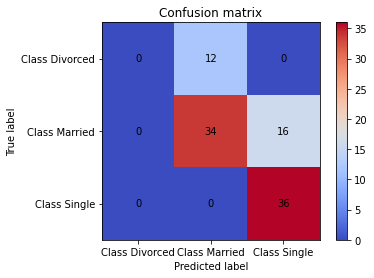

In [ ]:
!pip install sklearn-evaluation
!pip install black

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation import plot
plot.confusion_matrix(df_cut_notna['MaritalStatusTrue'], df_cut_notna['MaritalStatusPrediction'], cmap='coolwarm')

In [ ]:
#Ovviamente non predice nessun Divorced
#Proviamo a sostituire i NaN rimanenti della colonna MaritalStatusPrediction e a ricalcolare l'accuracy
df_cut["MaritalStatusPrediction"].fillna("Divorced", inplace = True) 

print('Accuracy %s' % accuracy_score(df_cut['MaritalStatusTrue'], df_cut['MaritalStatusPrediction']))
print('F1-score %s' % f1_score(df_cut['MaritalStatusTrue'], df_cut['MaritalStatusPrediction'], average=None))
print(classification_report(df_cut['MaritalStatusTrue'], df_cut['MaritalStatusPrediction']))
confusion_matrix(df_cut['MaritalStatusTrue'], df_cut['MaritalStatusPrediction'])


Accuracy 0.7207207207207207
F1-score [0.57 0.69 0.82]
              precision    recall  f1-score   support

    Divorced       0.77      0.45      0.57        22
     Married       0.74      0.64      0.69        53
      Single       0.69      1.00      0.82        36

    accuracy                           0.72       111
   macro avg       0.73      0.70      0.69       111
weighted avg       0.73      0.72      0.71       111



/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


array([[10, 12,  0],
       [ 3, 34, 16],
       [ 0,  0, 36]])

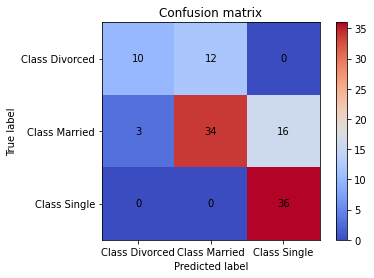

In [ ]:
plot.confusion_matrix(df_cut['MaritalStatusTrue'], df_cut['MaritalStatusPrediction'], cmap='coolwarm')

<h2>6. Use the most meaningful rules to predict the target variable and evaluate the accuracy (2 points)</h2>

<b> 6.1 - Preprocessing del Test Set </b>

In [ ]:
target_df = pd.read_csv(directory+"test_cleaned.csv",encoding="utf-8")
del target_df['Unnamed: 0']
target_df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,27.0,Yes,2.0,763,Sales,15,2,Medical,1,Male,59,1,2,Sales Executive,4,Divorced,4298.0,22098,6,Yes,14,3.0,4,2,7,1.0,2,2.0,2,2,2
1,30.0,Yes,1.0,1079,Sales,16,4,Marketing,1,Male,70,3,3,Sales Executive,3,Married,5304.0,19002,2,No,13,4.0,1,3,10,2.0,3,8.0,0,0,0
2,56.0,No,0.0,150,Research & Development,2,4,Technical Degree,4,Male,60,3,2,Manufacturing Director,4,Divorced,6306.0,17433,2,No,11,4.0,3,1,12,2.0,2,13.0,3,1,4
3,41.0,Yes,1.0,359,Human Resources,18,5,Human Resources,4,Male,89,4,1,Human Resources,1,Married,6430.0,21495,0,No,17,3.0,3,0,2,4.0,3,3.0,0,0,0
4,42.0,No,0.0,642,Research & Development,1,3,Life Sciences,4,Male,76,3,1,Research Scientist,4,Married,2766.0,21412,3,No,22,4.0,1,1,12,6.0,3,5.0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,38.0,No,1.0,890,Sales,2,3,Marketing,4,Male,97,3,1,Sales Representative,4,Married,8740.0,9687,1,No,13,3.0,1,0,2,2.0,3,8.0,2,2,2
290,44.0,No,1.0,1111,Sales,8,2,Life Sciences,3,Male,93,3,2,Sales Executive,1,Married,6465.0,13305,5,No,17,3.0,2,1,6,5.0,3,4.0,2,1,2
291,30.0,No,1.0,163,Research & Development,24,1,Technical Degree,4,Male,30,3,2,Manufacturing Director,4,Single,2476.0,6670,2,No,20,3.0,4,0,9,3.0,2,1.0,4,1,4
292,36.0,No,2.0,457,Research & Development,26,2,Other,2,Male,85,2,1,Research Scientist,3,Married,2088.0,10293,1,Yes,14,3.0,2,0,4,3.0,2,8.0,2,1,3


In [ ]:
target_df['AgeBin'] = pd.cut(target_df['Age'].astype(int), 4, right=False)
target_df['DailyRateBin'] = pd.cut(target_df['DailyRate'].astype(int), 5, right=False)
target_df['DistanceFromHomeBin'] = pd.cut(target_df['DistanceFromHome'].astype(int), 3, right=False)
target_df['HourlyRateBin'] = pd.cut(target_df['HourlyRate'].astype(int), 5, right=False)
target_df['MonthlyIncomeBin'] = pd.cut(target_df['MonthlyIncome'].astype(int), 5, right=False)
target_df['MonthlyRateBin'] = pd.cut(target_df['MonthlyRate'].astype(int), 5, right=False)
target_df['PercentSalaryHikeBin'] = pd.cut(target_df['PercentSalaryHike'].astype(int), 3, right=False)

target_df.drop(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike'], axis=1, inplace=True)

#target_df

In [ ]:
target_df['BusinessTravel'] = target_df['BusinessTravel'].astype(str) + '_BusinessTravel'
target_df['Attrition'] = target_df['Attrition'].astype(str) + '_Att'
target_df['Education'] = target_df['Education'].astype(str) + '_Edu'
target_df['EnvironmentSatisfaction'] = target_df['EnvironmentSatisfaction'].astype(str) + '_EnvironmentSatisf'
target_df['JobInvolvement'] = target_df['JobInvolvement'].astype(str) + '_JobInvolvement'
target_df['JobLevel'] = target_df['JobLevel'].astype(str) + '_JobLevel'
target_df['JobSatisfaction'] = target_df['JobSatisfaction'].astype(str) + '_JobSatisfaction'
target_df['PerformanceRating'] = target_df['PerformanceRating'].astype(str) + '_PerformanceRating'
target_df['RelationshipSatisfaction'] = target_df['RelationshipSatisfaction'].astype(str) + '_RelationshipSatisfaction'
target_df['YearsInCurrentRole'] = target_df['YearsInCurrentRole'].astype(str) + '_YearsInCurrentRole'
target_df['YearsSinceLastPromotion'] = target_df['YearsSinceLastPromotion'].astype(str) + '_YearsSinceLastPromotion'
target_df['YearsWithCurrManager'] = target_df['YearsWithCurrManager'].astype(str) + '_YearsWithCurrManager'
target_df['AgeBin'] = target_df['AgeBin'].astype(str) + '_Age'
target_df['DailyRateBin'] = target_df['DailyRateBin'].astype(str) + '_DailyRate'
target_df['HourlyRateBin'] = target_df['HourlyRateBin'].astype(str) + '_HourlyRate'
target_df['DistanceFromHomeBin'] = target_df['DistanceFromHomeBin'].astype(str) + '_DistanceFromHome'
df['MonthlyIncomeBin'] = target_df['MonthlyIncomeBin'].astype(str) + '_MonthlyIncome'
target_df['MonthlyRateBin'] = target_df['MonthlyRateBin'].astype(str) + '_MonthlyRate'
target_df['PercentSalaryHikeBin'] = target_df['PercentSalaryHikeBin'].astype(str) + '_PercentSalaryHike'
target_df['StockOptionLevel'] = target_df['StockOptionLevel'].astype(str) + '_StockOptionLevel'
target_df['TotalWorkingYears'] = target_df['TotalWorkingYears'].astype(str) + '_TotalWorkingYears'
target_df['TrainingTimesLastYear'] = target_df['TrainingTimesLastYear'].astype(str) + '_TrainingTimesLastYear'
target_df['WorkLifeBalance'] = target_df['WorkLifeBalance'].astype(str) + '_WorkLifeBalance'
target_df['YearsAtCompany'] = target_df['YearsAtCompany'].astype(str) + '_YearsAtCompany'
target_df['OverTime'] = target_df['OverTime'].astype(str) + '_OverTime'
target_df['NumCompaniesWorked'] = target_df['NumCompaniesWorked'].astype(str) + '_NumCompaniesWorked'

target_df.head()

,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBin,DailyRateBin,DistanceFromHomeBin,HourlyRateBin,MonthlyIncomeBin,MonthlyRateBin,PercentSalaryHikeBin
0,Yes_Att,2.0_BusinessTravel,Sales,2_Edu,Medical,1_EnvironmentSatisf,Male,1_JobInvolvement,2_JobLevel,Sales Executive,4_JobSatisfaction,Divorced,6_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,4_RelationshipSatisfaction,2_StockOptionLevel,7_TotalWorkingYears,1.0_TrainingTimesLastYear,2_WorkLifeBalance,2.0_YearsAtCompany,2_YearsInCurrentRole,2_YearsSinceLastPromotion,2_YearsWithCurrManager,"[18.0, 28.5)_Age","[664.6, 941.4)_DailyRate","[10.333, 19.667)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1393.0, 5103.0)","[21993.2, 26992.874)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
1,Yes_Att,1.0_BusinessTravel,Sales,4_Edu,Marketing,1_EnvironmentSatisf,Male,3_JobInvolvement,3_JobLevel,Sales Executive,3_JobSatisfaction,Married,2_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,1_RelationshipSatisfaction,3_StockOptionLevel,10_TotalWorkingYears,2.0_TrainingTimesLastYear,3_WorkLifeBalance,8.0_YearsAtCompany,0_YearsInCurrentRole,0_YearsSinceLastPromotion,0_YearsWithCurrManager,"[28.5, 39.0)_Age","[941.4, 1218.2)_DailyRate","[10.333, 19.667)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
2,No_Att,0.0_BusinessTravel,Research & Development,4_Edu,Technical Degree,4_EnvironmentSatisf,Male,3_JobInvolvement,2_JobLevel,Manufacturing Director,4_JobSatisfaction,Divorced,2_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,12_TotalWorkingYears,2.0_TrainingTimesLastYear,2_WorkLifeBalance,13.0_YearsAtCompany,3_YearsInCurrentRole,1_YearsSinceLastPromotion,4_YearsWithCurrManager,"[49.5, 60.042)_Age","[111.0, 387.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
3,Yes_Att,1.0_BusinessTravel,Human Resources,5_Edu,Human Resources,4_EnvironmentSatisf,Male,4_JobInvolvement,1_JobLevel,Human Resources,1_JobSatisfaction,Married,0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,2_TotalWorkingYears,4.0_TrainingTimesLastYear,3_WorkLifeBalance,3.0_YearsAtCompany,0_YearsInCurrentRole,0_YearsSinceLastPromotion,0_YearsWithCurrManager,"[39.0, 49.5)_Age","[111.0, 387.8)_DailyRate","[10.333, 19.667)_DistanceFromHome","[86.0, 100.07)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[15.667, 20.333)_PercentSalaryHike"
4,No_Att,0.0_BusinessTravel,Research & Development,3_Edu,Life Sciences,4_EnvironmentSatisf,Male,3_JobInvolvement,1_JobLevel,Research Scientist,4_JobSatisfaction,Married,3_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,1_RelationshipSatisfaction,1_StockOptionLevel,12_TotalWorkingYears,6.0_TrainingTimesLastYear,3_WorkLifeBalance,5.0_YearsAtCompany,3_YearsInCurrentRole,1_YearsSinceLastPromotion,0_YearsWithCurrManager,"[39.0, 49.5)_Age","[387.8, 664.6)_DailyRate","[1.0, 10.333)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[1393.0, 5103.0)","[17018.4, 21993.2)_MonthlyRate","[20.333, 25.014)_PercentSalaryHike"


6.1.1 - Inserisco la colonna su cui provare le nostre regole.

In [ ]:
#########GRAFICO CONFIDENCE-LIFT

In [ ]:
#calcolo la media del lift nelle regole cambiando la confidence (60,80) con un for
import statistics
lift_values = []
mean_values_list = []
for x in range(60,100):
    rules_for = apriori(baskets, target='r', supp=20, conf=x, report='ascl', zmin=2)
    for y in range(0,len(rules_for)):
        lift_values.append(rules_for[y][5])
    mean_values_list.append(statistics.mean(lift_values))

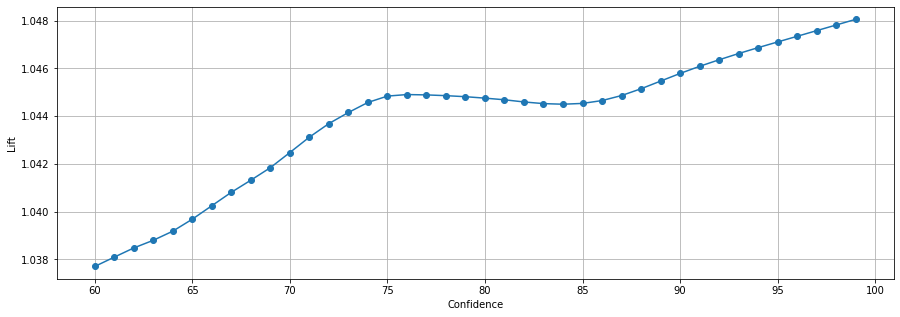

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(60, 100), mean_values_list, marker='o')
plt.ylabel('Lift')
plt.xlabel('Confidence')
plt.grid()
plt.show()

<h2><b>6.1.2 - Seleziono le Regole da Applicare!! </b></h2>

In [ ]:
len(rules_df[(rules_df['Consequent']=='No_Att')])

146

In [52]:
rules_no_att = rules_df[(rules_df['Consequent']=='No_Att') & (rules_df['Confidence']>=0.65) & (rules_df['sup_perc']>=30) ]
print(len(rules_no_att))
rules_no_att.sort_values(by=['Lift'], ascending=False)

85


,len_ant,Antecedent -->,Consequent,sup_count,sup_perc,Confidence,Lift
1867,2,"(Married, No_OverTime)",No_Att,342,30.755396,0.931880,1.114248
3990,3,"(Research & Development, No_OverTime, 1.0_Busi...",No_Att,352,31.654676,0.923885,1.104688
1115,2,"(1_StockOptionLevel, 3.0_PerformanceRating)",No_Att,357,32.104317,0.917738,1.097338
3705,2,"(3_WorkLifeBalance, No_OverTime)",No_Att,440,39.568345,0.916667,1.096057
3702,3,"(3_WorkLifeBalance, No_OverTime, 3.0_Performan...",No_Att,388,34.892086,0.915094,1.094177
...,...,...,...,...,...,...,...
2109,1,"(3.0_TrainingTimesLastYear,)",No_Att,428,38.489209,0.826255,0.987952
1242,1,"([4807.0, 8605.0)_MonthlyIncome,)",No_Att,372,33.453237,0.824834,0.986253
721,1,"(3_Edu,)",No_Att,356,32.014388,0.822171,0.983069
1526,1,"(0.0_YearsSinceLastPromotion,)",No_Att,375,33.723022,0.801282,0.958092


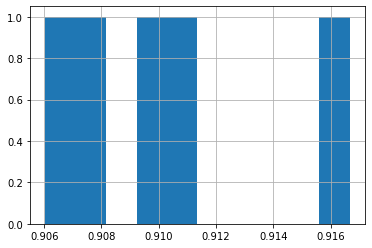

In [ ]:
rules_no_att['Confidence'].hist()

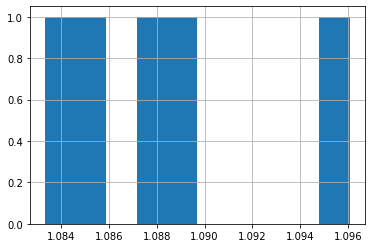

In [ ]:
rules_no_att['Lift'].hist()

In [ ]:
rules_yes_att = rules_df[(rules_df['Consequent']=='Yes_Att')  & (rules_df['Confidence']>=0.7) & (rules_df['sup_perc']>=0.35)]
print(len(rules_yes_att))
rules_yes_att.sort_values(by=['Lift'], ascending=False)
#OPS
#rules

0


,len_ant,Antecedent -->,Consequent,sup_count,sup_perc,Confidence,Lift


Problema: Nessuna regola che porta a Yes_attr! Ma ha senso, visto che Yes_Attr è comunque poco presente, quindi i pattern che lo contengono non possono avere un supporto maggiore del 17/18%, troppo basso. Strategia: riempire tutti i no_att e il resto lo consideriamo yes_att. <br>




NOTA: Applicando tutte le regole con NoAtt come conseguente, tutto il test set viene riempito con No! Bisogna selezionarne una parte, ad esempio solo quelle con confidence maggiore di una certa soglia!!!! <br> Fare varie prove e selezionare quello con miglior accuracy e/o precision/recall.

<b>6.2 - Applico le regole </b>

In [ ]:
target_df.insert(1,'Attr_Prediction','')
target_df['Attr_Prediction'] = 'Yes_Att' #SETTO A YES_ATT, così quelli che non vengono modificati dalle rules sono già yes!


In [ ]:
prediction_df = target_df.copy()

pred_values = prediction_df.values

#prendo tutte le regole con no_att come conseguente. Inserire qui un metodo di selezione.
antecedents = rules_no_att['Antecedent -->'].values

for n, item in enumerate(pred_values):
    set_tocheck = set(item)
    for rule in antecedents:
        myset = set(rule)
        if myset.issubset(set_tocheck):
            prediction_df.loc[n, 'Attr_Prediction'] = 'No_Att'
            break

print(len(prediction_df[prediction_df['Attr_Prediction']=='No_Att']))            
prediction_df           
#mylist = ['Yes_Att', 'No_Patterns', 'Yes_OverTime']
#myset = set(mylist)
#myset.issubset(set(prediction_df.values[0])) 
#df.loc[2, 'D1'] = 32

247


,Attrition,Attr_Prediction,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeBin,DailyRateBin,DistanceFromHomeBin,HourlyRateBin,MonthlyIncomeBin,MonthlyRateBin,PercentSalaryHikeBin
0,Yes_Att,Yes_Att,2.0_BusinessTravel,Sales,2_Edu,Medical,1_EnvironmentSatisf,Male,1_JobInvolvement,2_JobLevel,Sales Executive,4_JobSatisfaction,Divorced,6_NumCompaniesWorked,Yes_OverTime,3.0_PerformanceRating,4_RelationshipSatisfaction,2_StockOptionLevel,7_TotalWorkingYears,1.0_TrainingTimesLastYear,2_WorkLifeBalance,2.0_YearsAtCompany,2_YearsInCurrentRole,2_YearsSinceLastPromotion,2_YearsWithCurrManager,"[18.0, 28.5)_Age","[664.6, 941.4)_DailyRate","[10.333, 19.667)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[1393.0, 5103.0)","[21993.2, 26992.874)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
1,Yes_Att,No_Att,1.0_BusinessTravel,Sales,4_Edu,Marketing,1_EnvironmentSatisf,Male,3_JobInvolvement,3_JobLevel,Sales Executive,3_JobSatisfaction,Married,2_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,1_RelationshipSatisfaction,3_StockOptionLevel,10_TotalWorkingYears,2.0_TrainingTimesLastYear,3_WorkLifeBalance,8.0_YearsAtCompany,0_YearsInCurrentRole,0_YearsSinceLastPromotion,0_YearsWithCurrManager,"[28.5, 39.0)_Age","[941.4, 1218.2)_DailyRate","[10.333, 19.667)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
2,No_Att,No_Att,0.0_BusinessTravel,Research & Development,4_Edu,Technical Degree,4_EnvironmentSatisf,Male,3_JobInvolvement,2_JobLevel,Manufacturing Director,4_JobSatisfaction,Divorced,2_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,3_RelationshipSatisfaction,1_StockOptionLevel,12_TotalWorkingYears,2.0_TrainingTimesLastYear,2_WorkLifeBalance,13.0_YearsAtCompany,3_YearsInCurrentRole,1_YearsSinceLastPromotion,4_YearsWithCurrManager,"[49.5, 60.042)_Age","[111.0, 387.8)_DailyRate","[1.0, 10.333)_DistanceFromHome","[58.0, 72.0)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[11.0, 15.667)_PercentSalaryHike"
3,Yes_Att,No_Att,1.0_BusinessTravel,Human Resources,5_Edu,Human Resources,4_EnvironmentSatisf,Male,4_JobInvolvement,1_JobLevel,Human Resources,1_JobSatisfaction,Married,0_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,3_RelationshipSatisfaction,0_StockOptionLevel,2_TotalWorkingYears,4.0_TrainingTimesLastYear,3_WorkLifeBalance,3.0_YearsAtCompany,0_YearsInCurrentRole,0_YearsSinceLastPromotion,0_YearsWithCurrManager,"[39.0, 49.5)_Age","[111.0, 387.8)_DailyRate","[10.333, 19.667)_DistanceFromHome","[86.0, 100.07)_HourlyRate","[5103.0, 8813.0)","[17018.4, 21993.2)_MonthlyRate","[15.667, 20.333)_PercentSalaryHike"
4,No_Att,No_Att,0.0_BusinessTravel,Research & Development,3_Edu,Life Sciences,4_EnvironmentSatisf,Male,3_JobInvolvement,1_JobLevel,Research Scientist,4_JobSatisfaction,Married,3_NumCompaniesWorked,No_OverTime,4.0_PerformanceRating,1_RelationshipSatisfaction,1_StockOptionLevel,12_TotalWorkingYears,6.0_TrainingTimesLastYear,3_WorkLifeBalance,5.0_YearsAtCompany,3_YearsInCurrentRole,1_YearsSinceLastPromotion,0_YearsWithCurrManager,"[39.0, 49.5)_Age","[387.8, 664.6)_DailyRate","[1.0, 10.333)_DistanceFromHome","[72.0, 86.0)_HourlyRate","[1393.0, 5103.0)","[17018.4, 21993.2)_MonthlyRate","[20.333, 25.014)_PercentSalaryHike"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,No_Att,No_Att,1.0_BusinessTravel,Sales,3_Edu,Marketing,4_EnvironmentSatisf,Male,3_JobInvolvement,1_JobLevel,Sales Representative,4_JobSatisfaction,Married,1_NumCompaniesWorked,No_OverTime,3.0_PerformanceRating,1_RelationshipSatisfaction,0_StockOptionLevel,2_TotalWorkingYea

<b>6.3 - Valuto l'applicazione delle regole, costruendo la matrice di confusione </b>

In [ ]:
#Modo 1: A mano
"""TP = len(prediction_df[(prediction_df['Attrition']=='Yes_Att') & (prediction_df['Attr_Prediction']=='Yes_Att')])
TN = len(prediction_df[(prediction_df['Attrition']=='No_Att') & (prediction_df['Attr_Prediction']=='No_Att')])
FP = len(prediction_df[(prediction_df['Attrition']=='No_Att') & (prediction_df['Attr_Prediction']=='Yes_Att')])
FN = len(prediction_df[(prediction_df['Attrition']=='Yes_Att') & (prediction_df['Attr_Prediction']=='No_Att')])"""

"TP = len(prediction_df[(prediction_df['Attrition']=='Yes_Att') & (prediction_df['Attr_Prediction']=='Yes_Att')])\nTN = len(prediction_df[(prediction_df['Attrition']=='No_Att') & (prediction_df['Attr_Prediction']=='No_Att')])\nFP = len(prediction_df[(prediction_df['Attrition']=='No_Att') & (prediction_df['Attr_Prediction']=='Yes_Att')])\nFN = len(prediction_df[(prediction_df['Attrition']=='Yes_Att') & (prediction_df['Attr_Prediction']=='No_Att')])"

Accuracy 0.8231292517006803
F1-score [0.9  0.43]
              precision    recall  f1-score   support

      No_Att       0.90      0.89      0.90       249
     Yes_Att       0.43      0.44      0.43        45

    accuracy                           0.82       294
   macro avg       0.66      0.67      0.66       294
weighted avg       0.83      0.82      0.82       294



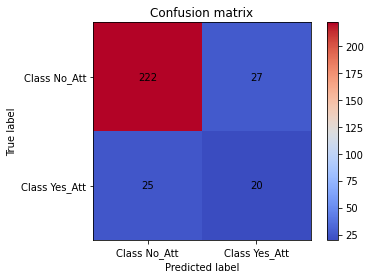

In [ ]:
print('Accuracy %s' % accuracy_score(prediction_df['Attrition'], prediction_df['Attr_Prediction']))
print('F1-score %s' % f1_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], average=None))
print(classification_report(prediction_df['Attrition'], prediction_df['Attr_Prediction']))
plot.confusion_matrix(prediction_df['Attrition'], prediction_df['Attr_Prediction'], cmap='coolwarm')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = dict()
column2encode = ['Attrition', 'Attr_Prediction']


for col in column2encode:
    le = LabelEncoder()
    prediction_df[col] = le.fit_transform(prediction_df[col])
    label_encoders[col] = le


fpr, tpr, _ = roc_curve(prediction_df['Attrition'], prediction_df['Attr_Prediction'])
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], average=None)

0.6680053547523427


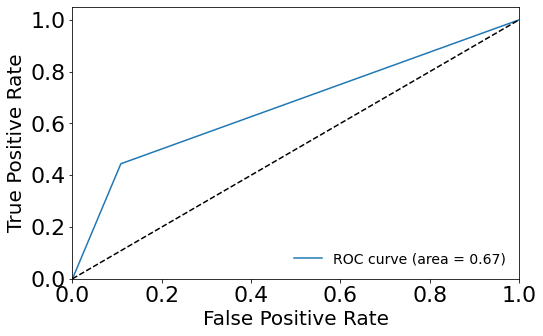

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

<h2>Prove automatizzate</h2>

In [ ]:
antecedent_list=[]
for conf in np.arange(0.70, 0.96, 0.05):
    for sup in np.arange(0.20, 0.80, 0.05):
        rules_no_att = rules_df[(rules_df['Consequent']=='No_Att') & (rules_df['Confidence']>=conf) & (rules_df['sup_perc']>=sup)]
        antecedent_list.append([(conf, sup)])
        antecedent_list[-1].append(rules_no_att['Antecedent -->'].values.tolist())
len(antecedent_list[0][1])

In [ ]:
import sklearn
report_dict = {'Min_Conf' : [], 'Min_Supp' : [], 'Num_Rules' : [], 'Accuracy' : [], 'F1-Score' : [], 'Precision' : [], 'Recall': []}

for n, combin in enumerate(antecedent_list):
    prediction_df = target_df.copy()
    pred_values = prediction_df.values

#prendo tutte le regole con no_att come conseguente. Inserire qui un metodo di selezione.
    antecedents = antecedent_list[n]

    for num, item in enumerate(pred_values):
        set_tocheck = set(item)
        for rule in antecedents[1]:
            myset = set(rule)
            if myset.issubset(set_tocheck):
                prediction_df.loc[num, 'Attr_Prediction'] = 'No_Att'
                break
                
    #print('conf:', antecedent_list[n][0][0], 'support: ', antecedent_list[n][0][1])
    report_dict['Min_Conf'].append(antecedent_list[n][0][0])
    report_dict['Min_Supp'].append(antecedent_list[n][0][1])
    report_dict['Num_Rules'].append(len(antecedent_list[n][1]))
    
    #print(len(prediction_df[prediction_df['Attr_Prediction']=='No_Att']))
    
    #print('Accuracy %s' % accuracy_score(prediction_df['Attrition'], prediction_df['Attr_Prediction']))
    report_dict['Accuracy'].append(accuracy_score(prediction_df['Attrition'], prediction_df['Attr_Prediction']))
    #print('F1-score %s' % f1_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], average=None))
    report_dict['F1-Score'].append(f1_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], pos_label="No_Att"))                               
    
    report_dict['Precision'].append(sklearn.metrics.precision_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], pos_label="Yes_Att"))
    report_dict['Recall'].append(sklearn.metrics.recall_score(prediction_df['Attrition'], prediction_df['Attr_Prediction'], pos_label="Yes_Att"))
                                   
                                   
    #print(classification_report(prediction_df['Attrition'], prediction_df['Attr_Prediction']))                               
    #print(confusion_matrix(prediction_df['Attrition'], prediction_df['Attr_Prediction']))
    #print()

report_df = pd.DataFrame(data = report_dict)
report_df

In [ ]:
report_df.sort_values(by='Accuracy', ascending=False)

In [ ]:
report_df['Recall'].hist()

In [ ]:
report_df[(report_df['Recall']>=0.4) & (report_df['Recall']<0.9)]

In [ ]:
rules_check = rules_df[(rules_df['Consequent']=='No_Att') & (rules_df['Confidence']>=0.9) & (rules_df['sup_perc']>=0.35)]
print(len(rules_check))
rules_check.sort_values(by=['sup_perc'], ascending=False)